Sentiment Analysis in python using two different techniques

- VADER (Valence Aware Dictionary and Sentiment Reasoner) - Bag of Words approach
- Huggingface 🤗 Roberta pretrained model
- Huggingface pipeline

# Column Description
- `ProductID`: Unique identifier of product
- `UserId`: Unique identifier of user
- `ProfileName`: User name
- `HelpfulnessNumerator`: Number of users who found the review helpful
- `HelpfulnessDenominator`: Number of users who indicated whether they found the review helpful or not
- `Score`: Rating between 1 and 5
- `Timestamp`: Timestapm for the review
- `Summary`: Brief summary of the review
- `Text`: Text of the review


# Import Libraries and Read Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Load Amazon Reviews. 
df = pd.read_csv('Reviews.csv')

# Drop Id column
df.drop('Id', inplace=True, axis=1)

# Dataset has +500K reviews. Reduce dataset to 500 rows
df = df.head(500)

In [3]:
# View first 500 rows of reviews
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

# EDA (Exploratory Data Analysis)

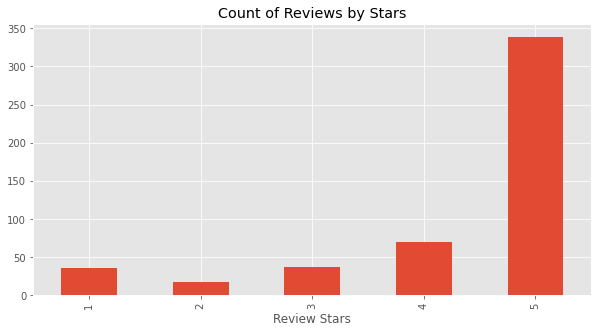

In [5]:
ax = df['Score'].value_counts().sort_index()\
    .plot(kind='bar',
    title = 'Count of Reviews by Stars',
    figsize=(10,5))

ax.set_xlabel('Review Stars')
plt.show()

# Model 1: VADER Sentiment Scoring

Uses "bag of words" approach
1. Stop words are removed
2. Each word is scored and combined to a total score

**Does not account for realtionships between words.

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
# Uncomment below line of code if error,
# nltk.download('vader_lexicon')
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [8]:
review_example = df.Text.values[50]
review_example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [9]:
sia.polarity_scores(review_example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [10]:
# Polarity score for each row
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = i
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
# Convert Polarity score to DataFrame
vaders = pd.DataFrame(res).T

# Merge to original dataset
vaders = vaders.merge(df, left_index=True, right_index=True)
vaders.head()

,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


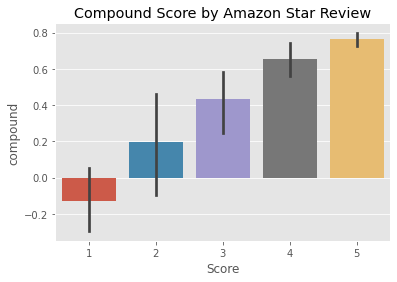

In [12]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

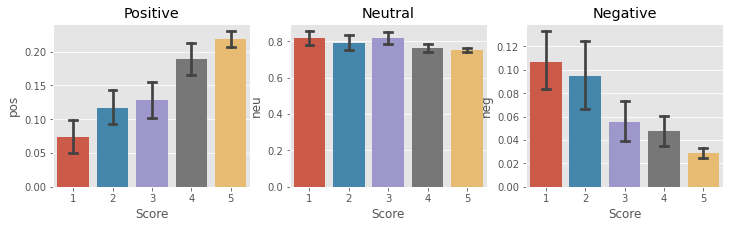

In [33]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
sns.barplot(data=vaders, x='Score', y='pos', capsize=.2, ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', capsize=.2,ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', capsize=.2, ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

# RoBERTa Pretrained Model
- Model trained on a large corpus of data
- Accounts for the context related to other words

In [14]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [15]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [16]:
# Polarity score for each row using RoBERTa Model
encoded_text = tokenizer(review_example, return_tensors='pt')
output = model(**encoded_text) # Unpack dictionary arguments for function
scores = output.logits.detach().numpy()[0] # Get tensor embbeding
scores = softmax(scores) # Normalize logits or raw values into probability values
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.02068747, 'roberta_pos': 0.0029573706}


In [17]:
# Define function to apply to all rows of dataset
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [18]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = i
        
        vader_result = sia.polarity_scores(text)
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 82
Broke for id 186


In [19]:
results_df = pd.DataFrame(res).T
results_df = results_df.merge(df, left_index=True, right_index=True)

In [20]:
results_df.head()

,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


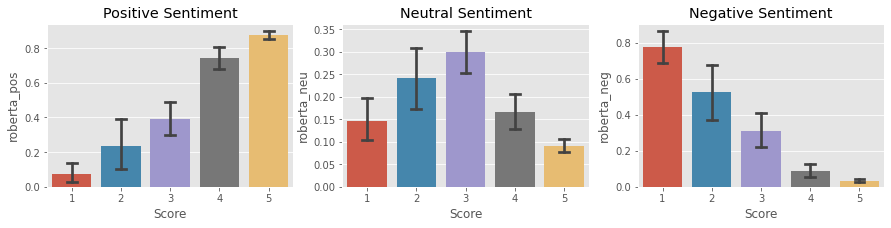

In [49]:
fig, axs = plt.subplots(1,3, figsize=(15,3))
sns.barplot(data=results_df, x='Score', y='roberta_pos', capsize=.2, ax=axs[0])
sns.barplot(data=results_df, x='Score', y='roberta_neu', capsize=.2,ax=axs[1])
sns.barplot(data=results_df, x='Score', y='roberta_neg', capsize=.2, ax=axs[2])
axs[0].set_title('Positive Sentiment')
axs[1].set_title('Neutral Sentiment')
axs[2].set_title('Negative Sentiment')
plt.show()

In [46]:
# # Save clean dataset for Streamlit app
# csv = results_df.copy()

# csv = csv[['roberta_neg', 'roberta_neu', 'roberta_pos',\
#     'Text', 'Summary', 'Score', 'ProfileName', 'UserId']]

# csv.head()

# csv.to_csv('Reviews_clean.csv', index=False)

# Compare Scores between models

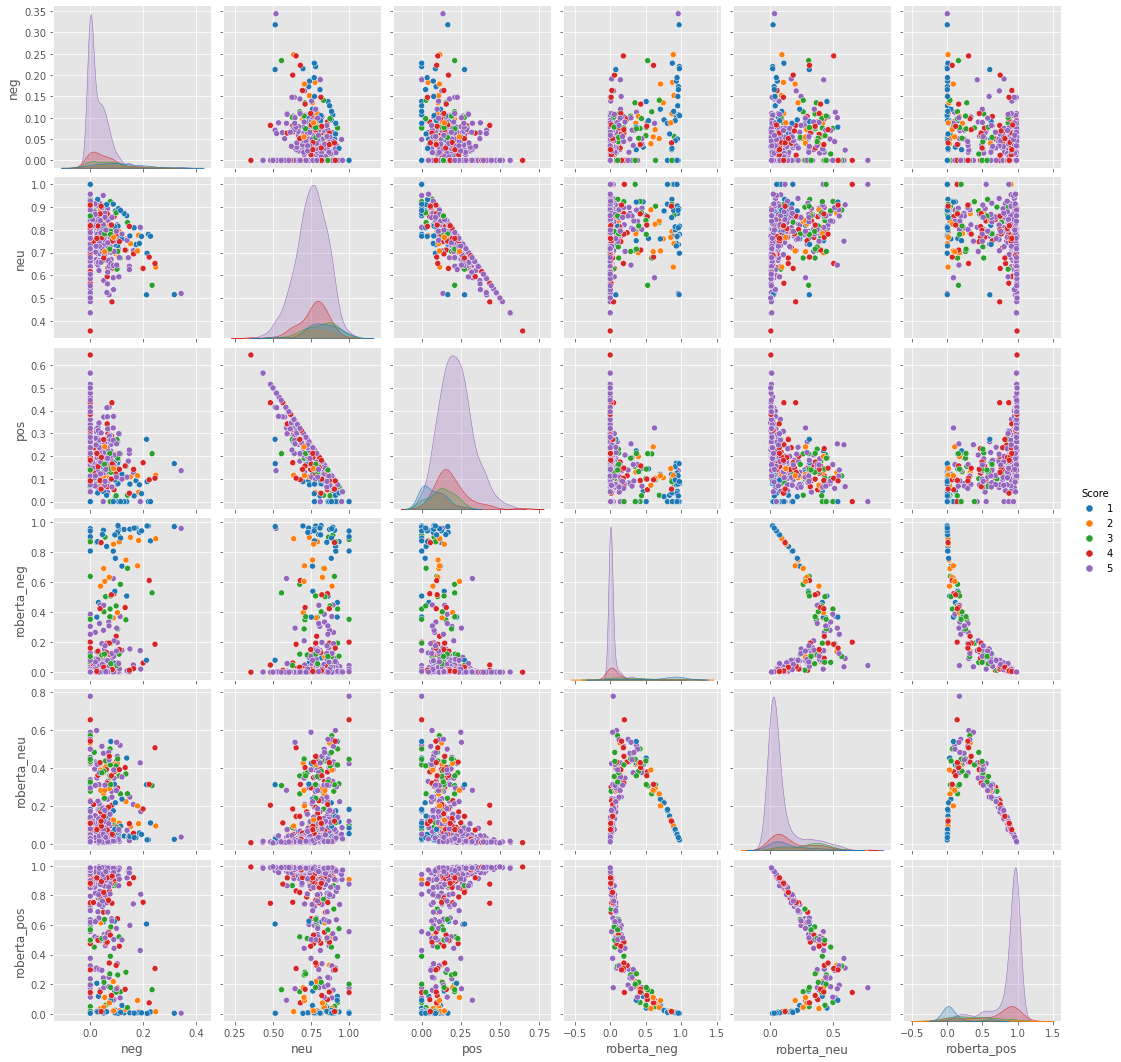

In [21]:
sns.pairplot(data=results_df,
vars=['neg', 'neu', 'pos',
'roberta_neg', 'roberta_neu', 'roberta_pos'],
hue='Score',
palette='tab10')
plt.show()

Review Examples
- Identify reviews where the model score and review score differ

In [22]:
false_pos = results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)
print(false_pos.shape)
false_pos.head()

(36, 16)


,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
254,0.091,0.736,0.172,0.4118,0.059614,0.314749,0.625637,B0048IC328,A1W867A8DSHFHC,no name,1,3,1,1339804800,Don't Waste Your Money,"I felt energized within five minutes, but it l..."
208,0.050,0.820,0.130,0.8913,0.095904,0.282240,0.621856,B0028C44Z0,A3BJ9NS09YGQT5,"Atl Chris ""Atl Chris""",0,3,1,1314489600,These just don't do it for me as breath mints,"To me, these are nothing like the regular Alto..."
324,0.213,0.514,0.274,0.3185,0.081018,0.311803,0.607180,B000JEHAHS,A2CU16YU1KEOUY,"Hurricane Ridge ""Chris""",5,19,1,1168300800,Never Arrived,So we cancelled the order. It was cancelled w...
164,0.025,0.752,0.223,0.8957,0.368308,0.425197,0.206495,B000ITVLE2,ARTBQH9WOZTIV,"Billy Wilson ""amzrview""",0,4,1,1269216000,Tasteless but low calorie,Seriously this product was as tasteless as the...
73,0.093,0.762,0.144,0.9665,0.541301,0.304906,0.153794,B0059WXJKM,A25VFHVGI4CFTP,Diana Robinson,0,1,1,1335744000,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...


[END]